In [719]:
cd ~/data/modl_data/pipeline/contrast/prediction/550

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/550


In [720]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline

In [721]:
estimator = load('estimator.pkl')

In [722]:
coef = estimator.named_steps['logistic_regression'].coef_
intercept = estimator.named_steps['logistic_regression'].intercept_
pipeline = Pipeline(estimator.steps[:-1])

In [725]:
(coef == 0).sum() / coef.size

0.51289682539682535

In [726]:
intercept

array([-55.86746284, -46.39580854, -66.1761534 , -13.54396382,
       -38.80129231, -43.96489722, -12.21796122, -29.8515356 ,
       -68.50011349,  -9.6273315 , -37.42492097, -21.34694723,
        -9.12988629, -15.54681135, -57.33496888, -60.88196246,
       -43.37022427, -36.11080804])

In [727]:
maps = pipeline.inverse_transform(coef)

In [728]:
from nilearn.input_data import MultiNiftiMasker

In [729]:
from modl.datasets.hcp import fetch_hcp
mask = fetch_hcp(n_subjects=1).mask

In [730]:
masker = MultiNiftiMasker(mask_img=mask).fit()

In [731]:
imgs = masker.inverse_transform(maps)

In [732]:
label_encoder = load('label_encoder.pkl')

In [733]:
import pandas as pd

In [734]:
labels = pd.read_csv('prediction.csv').loc[:18, 'contrast']
indices = label_encoder.transform(labels)

In [735]:
prediction = pd.read_csv('prediction.csv')
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)

In [736]:
prediction['match'].groupby(level=['fold', 'task', 'contrast']).apply(np.mean)

fold   task        contrast 
test   EMOTION     FACES        0.962025
                   SHAPES       0.898734
       GAMBLING    PUNISH       0.810127
                   REWARD       0.822785
       LANGUAGE    MATH         0.949367
                   STORY        0.924051
       MOTOR       LF           0.961538
                   LH           0.974359
                   T            0.974359
       RELATIONAL  MATCH        0.794872
                   REL          0.807692
       SOCIAL      RANDOM       0.935897
                   TOM          0.948718
       WM          2BK          0.962025
                   BODY-AVG     0.962025
                   FACE-AVG     0.962025
                   PLACE-AVG    0.974684
                   TOOL-AVG     0.924051
train  EMOTION     FACES        0.983027
                   SHAPES       0.980198
       GAMBLING    PUNISH       0.882768
                   REWARD       0.899718
       LANGUAGE    MATH         0.994342
                   STORY    

In [737]:
from sklearn.metrics import confusion_matrix

In [738]:
contrasts = prediction['true_label'].iloc[:18]
conf = confusion_matrix(prediction.loc['test', 'true_label'].values,
                        prediction.loc['test', 'predicted_label'], labels=contrasts)

In [739]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(10, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(conf_arr,
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=45)

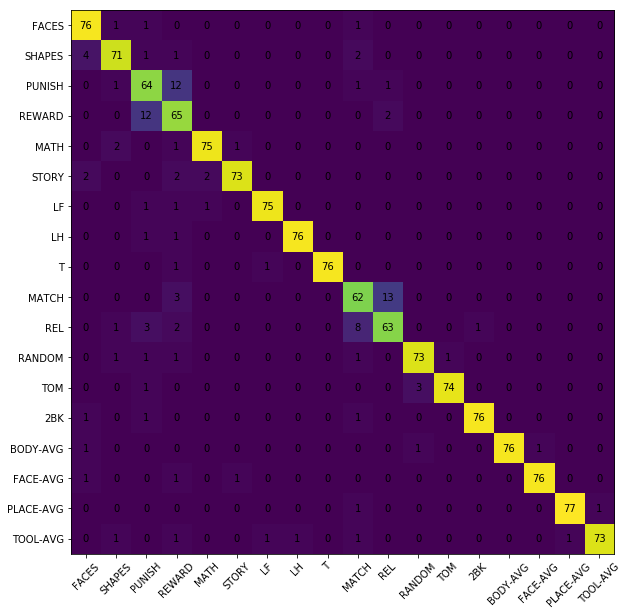

In [740]:
plot_confusion_matrix(conf, contrasts)

In [741]:
prediction['match'].groupby(level=['fold', 'task', 'contrast']).apply(np.mean)

fold   task        contrast 
test   EMOTION     FACES        0.962025
                   SHAPES       0.898734
       GAMBLING    PUNISH       0.810127
                   REWARD       0.822785
       LANGUAGE    MATH         0.949367
                   STORY        0.924051
       MOTOR       LF           0.961538
                   LH           0.974359
                   T            0.974359
       RELATIONAL  MATCH        0.794872
                   REL          0.807692
       SOCIAL      RANDOM       0.935897
                   TOM          0.948718
       WM          2BK          0.962025
                   BODY-AVG     0.962025
                   FACE-AVG     0.962025
                   PLACE-AVG    0.974684
                   TOOL-AVG     0.924051
train  EMOTION     FACES        0.983027
                   SHAPES       0.980198
       GAMBLING    PUNISH       0.882768
                   REWARD       0.899718
       LANGUAGE    MATH         0.994342
                   STORY    

In [742]:
title = pd.read_csv('prediction.csv').loc[:17, ['task', 'contrast']]

In [743]:
titles = ["%s: %s" % (value['task'], value['contrast']) for _, value in title.iterrows()]

/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


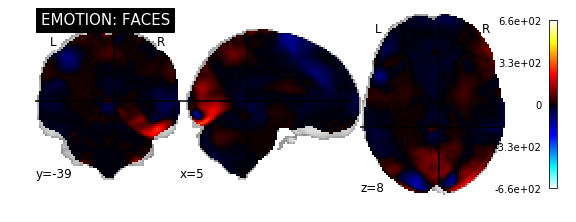

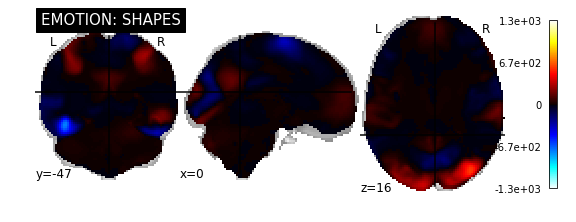

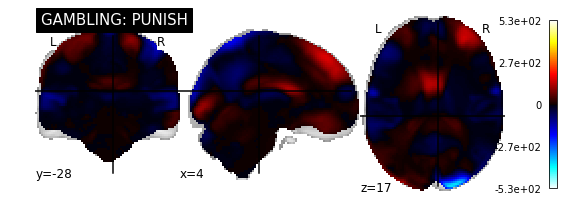

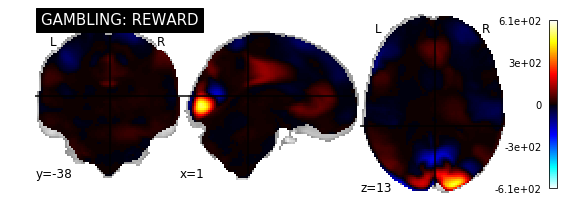

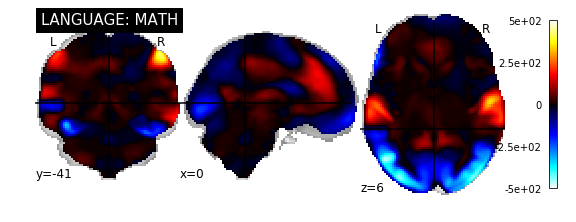

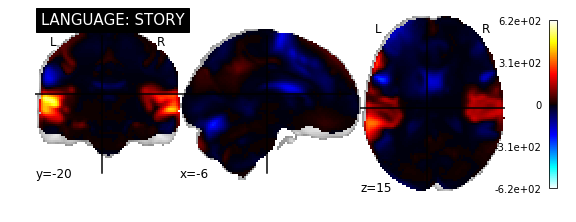

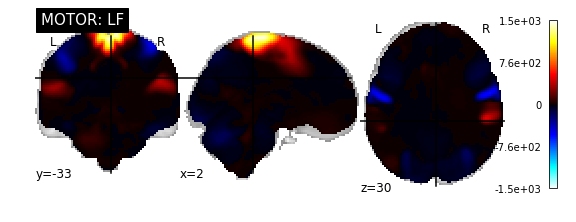

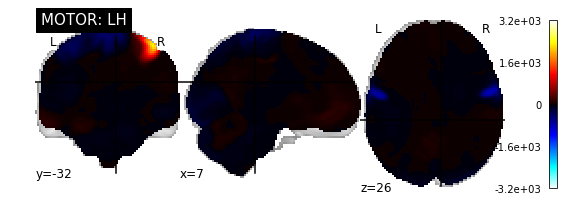

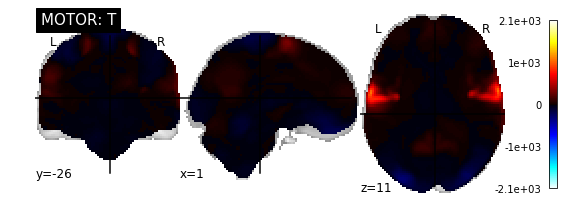

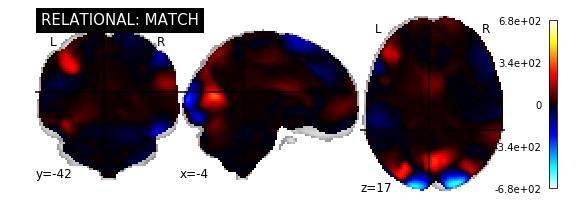

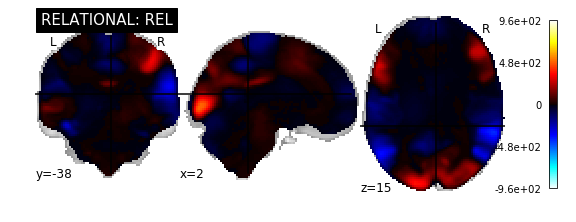

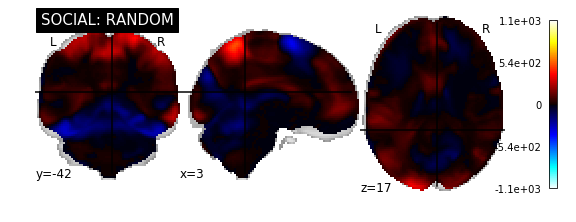

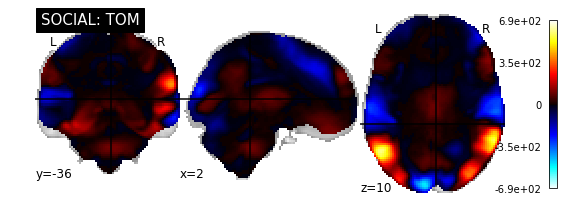

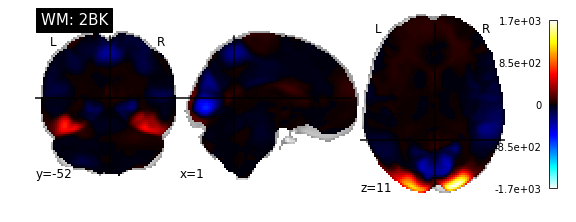

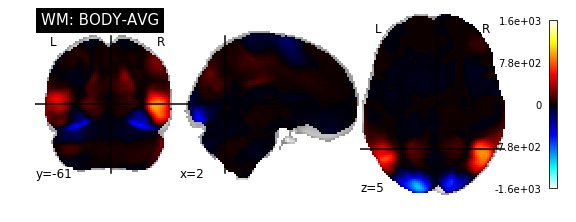

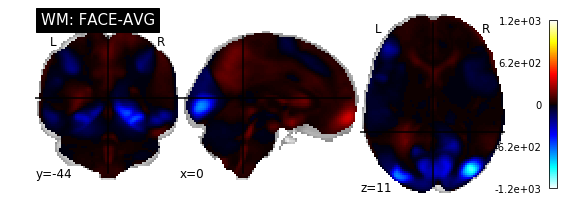

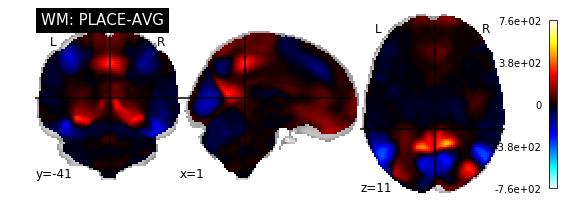

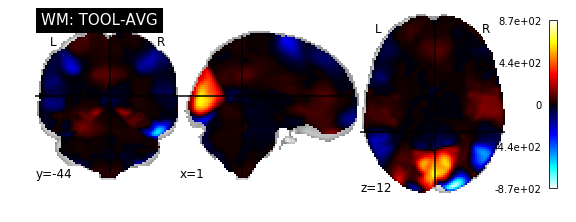

In [744]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title)

In [745]:
(np.abs(coef[:,:16]).sum())

633.21705504279987

In [746]:
(np.abs(coef[:,16:80])).sum()

2651.3414255110351

In [747]:
np.abs(coef[:,80:80 + 256]).sum()

9378.3666330025335

In [748]:
np.sum(coef[:, :16] == 0) / coef[:, :16].size

0.27430555555555558

In [749]:
np.sum(coef[:, 16:80] == 0) / coef[:, 16:80].size

0.41145833333333331

In [750]:
np.sum(coef[:, 80:256] == 0) / coef[:, 80:256].size

0.55429292929292928